In [3]:
# Extract data
import os
data_dir = 'D:\PJ\Python\ML-Practice\Book-DeepLearningWithPython\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
print(fname)
f = open(fname)
data = f.read()
f.close()

D:\PJ\Python\ML-Practice\Book-DeepLearningWithPython\jena_climate\jena_climate_2009_2016.csv


In [4]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [5]:
# Parsing data
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [ float(x) for x in line.split(',')[1:] ]
    float_data[i, :] = values

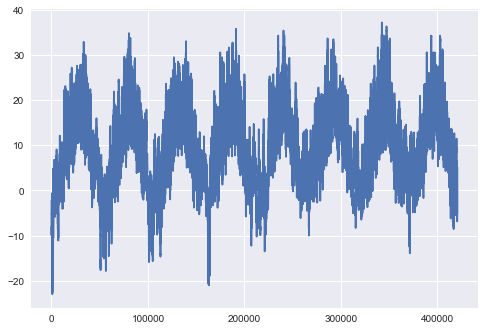

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')  
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)


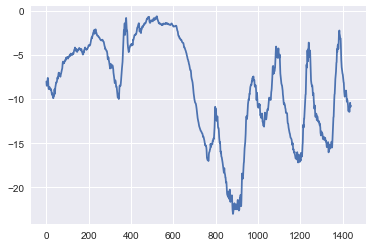

In [7]:
plt.plot(range(1440), temp[:1440])



In [8]:
# Data normalization: minus by mean, divide by std
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
# Define sequence generator
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
# Prepare generator for training, validation and test sets
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size



In [11]:
# Construct baseline
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        '''
        samples包含多个batch，每个batch为一个matrix，第一列是温度，这里仅仅拿最近一次的温度作为
        下一阶段温度的预测值，其他列不关心。所以这里的[:, -1, 1]，冒号表示选中所有batch，-1表示
        拿每个batch中的最后一个观测作为下一时刻的预测值。1表示只选中第一列（温度）
        '''
        preds = samples[:, -1, 1] 
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


In [12]:
celsius_mae = 0.29 * std[1]
print(celsius_mae)



2.5672247338393395


In [ ]:
# Construct a Fully-Connected model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
# 这里把每一个batch给Flatten掉，每个batch的维度为（多行，14列）其中第一列为温度，
# 其他列也作为训练的参数了，不光是温度
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps)


Epoch 1/20
495/500 [============================>.] - ETA: 0s - loss: 1.8683

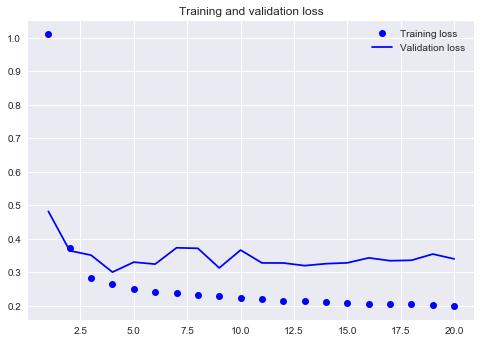

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.style.use('seaborn')  
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [17]:
mytrain = train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step)
myval = val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

mysample, mytarget = next(mytrain)


In [18]:
print(float_data.shape[-1])

14
